In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib.ticker import AutoMinorLocator
import os
import matplotlib as mpl
# from scipy.stats import bootstrap

# plt.style.use('/home/aussing/sty.mplstyle')
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 11
LITTLEH = 0.6688
UNITMASS = 1e10

In [2]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = (snap_data['Header'].attrs['Redshift'])
    return snap_data, haloinfo_data, z

In [3]:
def check_low_res(sim_directory,I_FILE):

    sn0 = h5py.File(sim_directory+'snapshot_000.hdf5','r')
    sn_I_FILE = h5py.File(sim_directory+f'snapshot_{str(I_FILE).zfill(3)}.hdf5','r')
    sub_I_FILE = h5py.File(sim_directory+f'fof_subhalo_tab_{str(I_FILE).zfill(3)}.hdf5','r')

    M200c = np.array(sub_I_FILE['Group']['Group_M_Crit200'], dtype=np.float64)
    R200c = np.array(sub_I_FILE['Group']['Group_R_Crit200'], dtype=np.float64)
    GrpPos = np.array(sub_I_FILE['Group']['GroupPos'], dtype=np.float64)

    box_size = sn0['Header'].attrs['BoxSize']
    h = sn0['Parameters'].attrs['HubbleParam']
    # massInterval = [(0.5e12/1.0e10)*h, (2e12/1.0e10)*h]
    massInterval = [(1.4e12/1.0e10)*h, (2e12/1.0e10)*h]
    i_mass_select = np.where( (M200c>massInterval[0]) & (M200c<massInterval[1]) )[0]

    # ISOLATION CRITERION
    minDist = 9.0*h
    # minDist = 9e3*h
    minMassDist = 0.5*massInterval[0]
    i_perturber = np.where( (M200c>minMassDist))[0]
    i_isolated = []
    for i_candidate in i_mass_select:
        dist2 = ( GrpPos[i_candidate,0] - GrpPos[i_perturber, 0] )**2 + \
        ( GrpPos[i_candidate,1] - GrpPos[i_perturber, 1] )**2 + \
        ( GrpPos[i_candidate,2] - GrpPos[i_perturber, 2] )**2
        i_ngb = np.where(dist2 < minDist**2)[0]
        if len(i_ngb) < 2:   ## always should contain itself
            i_isolated.append(i_candidate)
        
            
    # SELECTION OF THE MOST CENTRAL GALAXY (CLOSEST TO CENTER OF BOX)
    BoxHalf = box_size/2
    dists = []
    for i_candidate in i_isolated:
        dist2 = ( GrpPos[i_candidate, 0] - BoxHalf)**2 + \
        ( GrpPos[i_candidate, 1] - BoxHalf)**2 + \
        ( GrpPos[i_candidate, 2] - BoxHalf)**2
        dists.append(np.sqrt(dist2))
    dists = np.array(dists)

    i_select = np.where(dists == np.min(dists))[0][0]
    i_halo = i_isolated[i_select]
    pos = GrpPos[i_halo, :]
    print('Selected halo %d \nPosition %g %g %g'%(i_halo, pos[0], pos[1], pos[2]))

    print(f'Mass of selected halo = {np.round(M200c[i_halo],4)} ^12 M_sun/h')    
    mass_target = M200c[i_halo]
    return mass_target, pos


In [4]:
def check_zoom(sim_directory,I_FILE):

    snap_data, haloinfo_data, z = get_sim_data(sim_directory,I_FILE)
    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) 
    halo_mass  = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH

    mass_mask = np.argsort(halo_mass)[::-1]
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.int32) * UNITMASS / LITTLEH
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]
    # print('Halo pos = ',halo_pos[mass_mask[halo_mainID]])
    main_halo_mass = halo_mass[mass_mask[halo_mainID]]
    main_halo_pos = halo_pos[mass_mask[halo_mainID]]
    
    return main_halo_mass, main_halo_pos


In [ ]:
def compare_tree(tree_dir, target_mass, target_pos,normalisation=True):
    tree_data = h5py.File(f'{tree_dir}/trees.hdf5', 'r')
    Group_m_200c = np.array(tree_data['TreeHalos/Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    Group_mass = np.array(tree_data['TreeHalos/Group_Mass'], dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass = np.array(tree_data['TreeHalos/SubhaloMass'], dtype=np.float64) * UNITMASS / LITTLEH
    Main_prog = np.array(tree_data['TreeHalos/TreeMainProgenitor'])
    snap_num = np.array(tree_data['TreeHalos/SnapNum'])
    scale_factor = np.array(tree_data['TreeTimes/Time'])
    subhalo_pos = np.array(tree_data['TreeHalos/SubhaloPos'], dtype=np.float64)
    TreeId = np.array(tree_data['TreeHalos/TreeID'])
    redshift = np.array(tree_data['TreeTimes/Redshift'])
    first_halo_in_FOF_group = np.array(tree_data['TreeHalos/TreeFirstHaloInFOFgroup'])
    eps = 1e-5
    a = np.unique(np.where(np.abs(subhalo_pos-target_pos)<eps)[0])
    b = np.where(np.abs(subhalo_mass-target_mass)<10*UNITMASS)[0]
    c = np.where(snap_num==np.max(snap_num))
    
    # index = int(a[np.isin(a,b,c)][0])
    index = int(a[np.isin(a,c)][0])
    # if len(a[np.isin(a,c)]) > 1:
    #     raise Exception
    # print(a,index)
    tree_ID = np.where(TreeId==TreeId[index])[0]
    
    tree_group_mass = Group_m_200c[tree_ID]
    # tree_group_mass = subhalo_mass[tree_ID]
    
    tree_snapnumber = snap_num[tree_ID]

    tree_main_prog = Main_prog[tree_ID]
    FHIFG = first_halo_in_FOF_group[tree_ID]
    # print(FHIFG)
    # print(FHIFG.shape)
    snapnum_list = np.zeros(len(scale_factor))
    mah = np.zeros(len(scale_factor))#* [0,]
    i = 0
    # print(tree_main_prog.shape)
    # print(tree_main_prog.dtype)
    while tree_main_prog[i]!=-1:
        # print(tree_snapnumber[i])
        mah[tree_snapnumber[i]] = tree_group_mass[i]
        # print(i, tree_group_mass[i]/UNITMASS)
        snapnum_list[tree_snapnumber[i]]=tree_snapnumber[i]
        # print(tree_snapnumber[i])
        # print('FHIFG     = ',FHIFG[tree_snapnumber[i]])
        # print('Main prog = ',tree_main_prog[tree_snapnumber[i]],'\n')
        if tree_main_prog[FHIFG[i]] != tree_main_prog[i]:
            i = FHIFG[i]
            print('aaaaa')
        else:
            i = tree_main_prog[i]
            # print(tree_snapnumber[i])
    if normalisation:
        mah = mah/mah[-1]
    else:
        mah = mah/UNITMASS
    return scale_factor, mah


In [6]:
i_file = 26
folder_list = []
for simulation_name in [ simulation_name for simulation_name in os.listdir('/fred/oz217/aussing/') if ( simulation_name.startswith("N2048_L65_sd") )]:
    folder_list.append(simulation_name)
folder_list = np.sort(folder_list)
print(folder_list)

['N2048_L65_sd00372' 'N2048_L65_sd01829' 'N2048_L65_sd02640'
 'N2048_L65_sd03157' 'N2048_L65_sd04721' 'N2048_L65_sd05839'
 'N2048_L65_sd06382' 'N2048_L65_sd07409' 'N2048_L65_sd08230'
 'N2048_L65_sd09675' 'N2048_L65_sd10739' 'N2048_L65_sd11000'
 'N2048_L65_sd12000' 'N2048_L65_sd13000' 'N2048_L65_sd14000'
 'N2048_L65_sd17492' 'N2048_L65_sd28504' 'N2048_L65_sd34920'
 'N2048_L65_sd46371' 'N2048_L65_sd57839' 'N2048_L65_sd61284'
 'N2048_L65_sd70562' 'N2048_L65_sd80325' 'N2048_L65_sd93745']


/tmp/ipykernel_498960/2123048221.py:23: RuntimeWarning: invalid value encountered in divide
  mah_ratio = mah_cdm_010/mah_wdm_005
/tmp/ipykernel_498960/2123048221.py:23: RuntimeWarning: divide by zero encountered in divide
  mah_ratio = mah_cdm_010/mah_wdm_005
/home/aussing/external/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Low WDM Gini  -> simulation = N2048_L65_sd06382, mah = 100.12102678846801
High WDM Gini -> simulation = N2048_L65_sd07409, mah = 99.71014042094566
High WDM Gini -> simulation = N2048_L65_sd28504, mah = 99.2332837429014
Low WDM Gini  -> simulation = N2048_L65_sd46371, mah = 109.10250370580677
Low WDM Gini  -> simulation = N2048_L65_sd70562, mah = 101.01039638700387
High WDM Gini -> simulation = N2048_L65_sd80325, mah = 99.04507026247809
(24, 27)


Text(0.5, 1.0, 'Total Mass Accretion History Ratio')

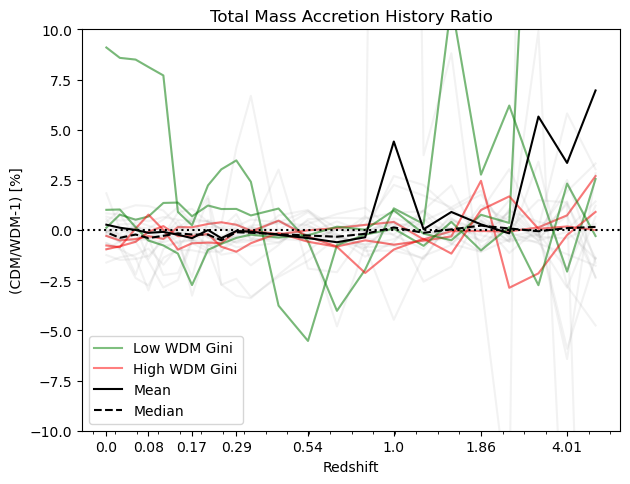

In [68]:
sn_list = ['sn_005','sn_010']
dm_list = ['cdm','wdm_3.5']
# for dm in dm_list :
#     # print(dm)
#     for sn in sn_list:
#         # print(sn)
#         fig, ax = plt.subplots()
#         mah_list = []
fig, ax = plt.subplots()
std_dev_low = []
std_dev_high = []
mah_all = []
for folder in folder_list:
    snap_location_cdm_010 = f'/fred/oz217/aussing/{folder}/cdm/zoom/output/sn_010/'
    mass_cdm_010, position_cdm_010 = check_zoom(snap_location_cdm_010,i_file)
    scale_factor_cdm_010, mah_cdm_010 = compare_tree(snap_location_cdm_010, mass_cdm_010, position_cdm_010, normalisation=False)
    
    snap_location_wdm_005 = f'/fred/oz217/aussing/{folder}/wdm_3.5/zoom/output/sn_005/'
    mass_wdm_005, position_wdm_005 = check_zoom(snap_location_wdm_005,i_file)
    scale_factor_wdm_005, mah_wdm_005 = compare_tree(snap_location_wdm_005, mass_wdm_005, position_wdm_005, normalisation=False)

    redshift = np.round(1/scale_factor_wdm_005-1,2)
    mah_ratio = mah_cdm_010/mah_wdm_005
    mah_all.append(mah_ratio)
    x_ax = scale_factor_wdm_005[5::3]
    x_label = np.round(1/scale_factor_wdm_005-1,2)[5::3]
    plt.plot(scale_factor_wdm_005,(mah_ratio-1)*100, alpha=0.1,c='gray')

    ratio_std_dev = np.nanstd(mah_ratio)
    ratio_mean = np.nanmean(mah_ratio)
    # if ratio_std_dev < 0.01:
    #     plt.plot(scale_factor_wdm_005,mah_ratio*100, alpha=1,c='lime')
    # if ratio_mean > 1:
    #     plt.plot(scale_factor_wdm_005,mah_ratio*100, alpha=1,c='k')

    if folder in ['N2048_L65_sd06382','N2048_L65_sd70562','N2048_L65_sd46371']:
    # # if folder in ['N2048_L65_sd06382','N2048_L65_sd70562','N2048_L65_sd46371','N2048_L65_sd57839','N2048_L65_sd17492']:
    # # if folder in ['N2048_L65_sd00372', 'N2048_L65_sd02640', 'N2048_L65_sd03157', 'N2048_L65_sd05839' ,'N2048_L65_sd06382', 'N2048_L65_sd09675', 'N2048_L65_sd10739' ,'N2048_L65_sd11000', 'N2048_L65_sd13000', 'N2048_L65_sd14000' ,'N2048_L65_sd17492', 'N2048_L65_sd46371', 'N2048_L65_sd57839' ,'N2048_L65_sd61284', 'N2048_L65_sd70562', 'N2048_L65_sd93745']:
        low_gini, = plt.plot(scale_factor_wdm_005,(mah_ratio-1)*100, alpha=0.5,c='green')#,label="Low Gini")
        print(f'Low WDM Gini  -> simulation = {folder}, mah = {mah_ratio[-1]*100}')
    #     # print(f'mean ratio -> {np.nanmean(mah_ratio)}, std-dev = {np.nanstd(mah_ratio)}')
    #     std_dev_low.append(np.nanstd(mah_ratio))

    if folder in ['N2048_L65_sd80325' ,'N2048_L65_sd07409' ,'N2048_L65_sd28504']:
    # # if folder in ['N2048_L65_sd04721' ,'N2048_L65_sd07409' ,'N2048_L65_sd12000', 'N2048_L65_sd28504', 'N2048_L65_sd34920', 'N2048_L65_sd80325']:
        high_gini, = plt.plot(scale_factor_wdm_005,(mah_ratio-1)*100, alpha=0.5,c='red')#,label="High Gini")
        print(f'High WDM Gini -> simulation = {folder}, mah = {mah_ratio[-1]*100}')
    #     # print(f'mean ratio -> {np.nanmean(mah_ratio)}, std-dev = {np.nanstd(mah_ratio)}\n')
    #     std_dev_high.append(np.nanstd(mah_ratio))
mah_all = np.array(mah_all)
print(mah_all.shape)
mah_mean_ratio = np.mean(mah_all,axis=0)
mah_median_ratio = np.median(mah_all,axis=0)

mean_line,   = plt.plot(scale_factor_wdm_005,(mah_mean_ratio-1)*100,alpha=1,c='k',label='Mean')
median_line, = plt.plot(scale_factor_wdm_005,(mah_median_ratio-1)*100,alpha=1,c='k',ls='--',label='Median')

handles = (low_gini, high_gini, mean_line, median_line)
Labels = ['Low WDM Gini', 'High WDM Gini', 'Mean', 'Median']
# print(np.mean(np.array(std_dev_low)))
# print(np.mean(np.array(std_dev_high)))

plt.axhline(0,ls=':',c='k')

plt.xticks(x_ax,x_label )
ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.gca().invert_xaxis()
# plt.ylabel(r'$M_{200c}$/$M_{200c, z=0}$')
plt.ylabel(r'(CDM/WDM-1) [%]')
plt.xlabel('Redshift')

plt.ylim(-10,10)
plt.tight_layout()
# [line1, line2, line3], ['label1', 'label2', 'label3']
plt.legend(handles,Labels,loc='lower left')
plt.title("Total Mass Accretion History Ratio")